# 1. Installing and Importing Libraries

In [1]:
!pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00


In [2]:
!pip install torchinfo

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchinfo import summary

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 2. Fetching Data and EDA

In [30]:
# we get the data from github
!wget https://github.com/banglanlp/bangla-sentiment-classification/raw/main/data/multichannel_bsentiment/multichannel_bsentiment_train.tsv
!wget https://github.com/banglanlp/bangla-sentiment-classification/raw/main/data/multichannel_bsentiment/multichannel_bsentiment_dev.tsv
!wget https://github.com/banglanlp/bangla-sentiment-classification/raw/main/data/multichannel_bsentiment/multichannel_bsentiment_test.tsv

df1 = pd.read_csv('/content/multichannel_bsentiment_train.tsv',sep='\t')
df2 = pd.read_csv('/content/multichannel_bsentiment_dev.tsv',sep='\t')
df3 = pd.read_csv('/content/multichannel_bsentiment_test.tsv',sep='\t')

df = pd.concat([df1, df2, df3]).reset_index(drop=True)
df.drop(["id"], axis=1, inplace=True)
df.head()

--2024-10-14 13:39:03--  https://github.com/banglanlp/bangla-sentiment-classification/raw/main/data/multichannel_bsentiment/multichannel_bsentiment_train.tsv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/banglanlp/bangla-sentiment-classification/main/data/multichannel_bsentiment/multichannel_bsentiment_train.tsv [following]
--2024-10-14 13:39:04--  https://raw.githubusercontent.com/banglanlp/bangla-sentiment-classification/main/data/multichannel_bsentiment/multichannel_bsentiment_train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245386 (1.2M) [text/plain]
Saving to: ‘multichannel_bsen

,text,class_label
0,আল্লাহ অবশ্যই এদের পাশে থাকবে।,Positive
1,বেগম খালেদা জিয়া সঠিক বলেছেন।,Positive
2,ভারতীয় অনূর্ধ্ব-১৯ দলের কোচ ম্যাচ শেষে পাকিস্...,Positive
3,খুব গুরুত্ব পূর্ন একটি ভাল সিদ্ধান্ত রাজ্জাক ভ...,Positive
4,এই বাভে যদি সফর করা যেত মানুষ আর লক্ষ লক্ক টা...,Negative


In [32]:
df["class_label"].value_counts()

,count
class_label,
Negative,4634
Positive,3786


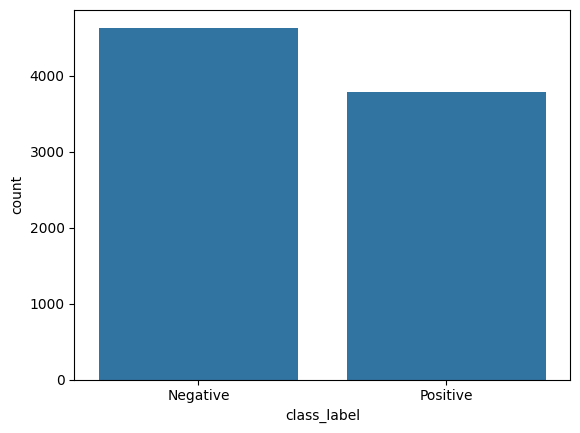

In [41]:
sns.barplot(df["class_label"].value_counts());

* we can see that the number of classes are almost equal

In [64]:
texts = df["text"].tolist()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)
word_counts = X.toarray().sum(axis=0)
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'count': word_counts
})

print("Most Common Words\n-------------------\n", word_freq.sort_values(by='count', ascending=False).head(20))

Most Common Words
-------------------
      word  count
1071   কর   2958
529    আম   2038
1358   জন   1358
884    এব   1063
536    আর   1046
824   একট    994
788    এই    937
309    অন    907
1888   পর    884
499   আপন    870
2823   হয়    843
2173   মন    802
2363   রত    801
2801   হব    703
2677   সব    647
2045   বল    633
2812   হল    618
860    এট    593
989    ওয়    563
899    এর    560


# 3. Pre-Processing Data

In [5]:
# we change the column names and the label type for the huggingface api
target_maps = {"Positive" : 1, "Negative" : 0}
df["class_label"] = df["class_label"].map(target_maps)
df.columns = ["sentence", "label"]
df.head()

,sentence,label
0,আল্লাহ অবশ্যই এদের পাশে থাকবে।,1
1,বেগম খালেদা জিয়া সঠিক বলেছেন।,1
2,ভারতীয় অনূর্ধ্ব-১৯ দলের কোচ ম্যাচ শেষে পাকিস্...,1
3,খুব গুরুত্ব পূর্ন একটি ভাল সিদ্ধান্ত রাজ্জাক ভ...,1
4,এই বাভে যদি সফর করা যেত মানুষ আর লক্ষ লক্ক টা...,0


In [6]:
df.to_csv("data.csv", index=None)

In [7]:
!head data.csv

sentence,label
 আল্লাহ অবশ্যই এদের পাশে থাকবে। ,1
 বেগম খালেদা জিয়া সঠিক বলেছেন। ,1
 ভারতীয় অনূর্ধ্ব-১৯ দলের কোচ ম্যাচ শেষে পাকিস্তানের ড্রেসিংরুমে গিয়ে সবাইকে সান্ত্বনা দিয়েছেন।,1
খুব গুরুত্ব পূর্ন একটি ভাল সিদ্ধান্ত রাজ্জাক ভাইকে ফিরিয়ে আনার জন্য ।,1
 এই বাভে যদি সফর করা যেত মানুষ আর লক্ষ লক্ক টাকা করছ করে বিদেশে যেত না ,0
ছাব্বির তো মনে হয় গুণ্ডামি করতে মাঠে নামে। তারপর চোখে সরষে ফুল দেখে নিজেই অক্কা পায়।,0
"হাতুরে গংরা নিপাত যাক,প্রতিভা মুক্তি পাক।",0
তারা ঘরোয়া লীগ খেলে যে টাকা পায় জাতীয় দলে খেলেও সে টাকা পায় না। তবে কেনো বেতন বাড়াবে? ,0
 পংগা মারুক হিলারি গহা মারুক ,0


In [8]:
# we create our huggingface transformer dataset
raw_dataset = load_dataset("csv", data_files="data.csv")
raw_dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8420
    })
})

In [9]:
raw_dataset["train"][0]

{'sentence': ' আল্লাহ অবশ্যই এদের পাশে থাকবে। ', 'label': 1}

In [10]:
# split the data for training and testing
split_data = raw_dataset["train"].train_test_split(test_size=0.3, seed=42)
split_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 5894
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2526
    })
})

In [11]:
# create tokenizer object with the AutoTokenizer class
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
split_data["train"][0]['sentence']

'বেশ কয়েক বছর ধরে  যতন করে রেখেছে এবং খাবারটি চমৎকার।'

In [13]:
tokenizer(split_data["train"][0]['sentence'])

{'input_ids': [101, 1368, 29917, 29910, 1353, 29907, 29917, 29889, 1368, 29893, 29908, 1365, 29908, 29917, 1371, 29898, 29902, 1353, 29908, 29917, 1372, 29917, 29890, 29917, 29893, 29917, 1351, 29904, 29882, 1354, 29914, 29904, 29914, 29908, 29895, 29915, 100, 1344, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
# we only set truncation as padding is handled by the trainer object
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [15]:
tokenized_dataset = split_data.map(tokenize_fn, batched=True)

Map:   0%|          | 0/5894 [00:00<?, ? examples/s]

Map:   0%|          | 0/2526 [00:00<?, ? examples/s]

# 4. Creating Model and Training

In [16]:
# we create our model instance
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [18]:
training_args = TrainingArguments(
    output_dir='training_dir',
    eval_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=62,
    logging_steps=100
)

In [19]:
# we need to provide the trainer object with metrics function so that we can see the matrics as we train and evaluate
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy' : acc, 'f1' : f1}

In [20]:
# we create trainer object
trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.593400,0.589740,0.724861,0.720845
2,0.533300,0.520858,0.756928,0.748211
3,0.447800,0.506292,0.765637,0.764247


TrainOutput(global_step=1107, training_loss=0.5248673595387116, metrics={'train_runtime': 754.6616, 'train_samples_per_second': 23.43, 'train_steps_per_second': 1.467, 'total_flos': 1659156731771400.0, 'train_loss': 0.5248673595387116, 'epoch': 3.0})

# 5. Evaluation

In [22]:
# we load our saved model with Pipeline api
from transformers import pipeline
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1107',
                      device=0)

In [23]:
# we get the predictions
test_pred = savedmodel(split_data["test"]['sentence'])

In [24]:
test_pred[:5]

[{'label': 'LABEL_1', 'score': 0.7230148315429688},
 {'label': 'LABEL_1', 'score': 0.8513554334640503},
 {'label': 'LABEL_1', 'score': 0.8452995419502258},
 {'label': 'LABEL_0', 'score': 0.8896544575691223},
 {'label': 'LABEL_1', 'score': 0.8818155527114868}]

In [25]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]
test_pred[:10]

[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]

In [26]:
# we calculate accuracy and f1 score from the predictions
print("Accuracy:", accuracy_score(split_data['test']['label'], test_pred))
print("F1 Score:", f1_score(split_data['test']['label'], test_pred, average='macro'))

Accuracy: 0.765637371338084
F1 Score: 0.7642467964887498


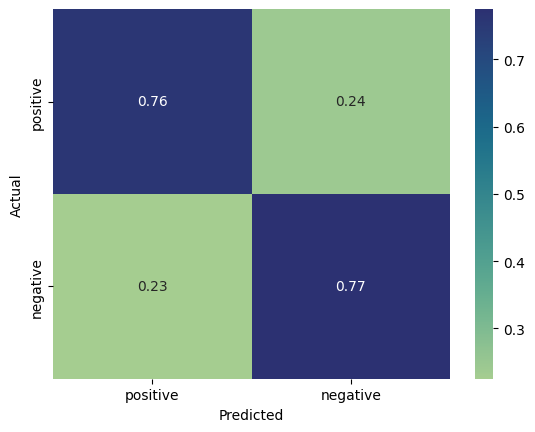

In [27]:
# we plot the confusion matrix
cm = confusion_matrix(split_data['test']['label'], test_pred, normalize='true')
classes = ["positive", "negative"]
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
ax = sns.heatmap(df_cm, annot=True, cmap="crest")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual");